# Class Prior Estimation in Active Positive and Unlabeled Learning

In [ ]:
###If you do not have installed cython, run:
#!pip install cython 

### or, in case of problems with cython, run:
#!pip install -U --force-reinstall Cython 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
from SSAD_functions import *
from sklearn.neighbors import KernelDensity
from multiprocessing import Pool, freeze_support, cpu_count
from anomatools.models import SSDO
from sklearn.ensemble import IsolationForest
import pyximport
pyximport.install()
from CAPe import *

def ignore_warnings():
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)

ignore_warnings()

# Generate examples

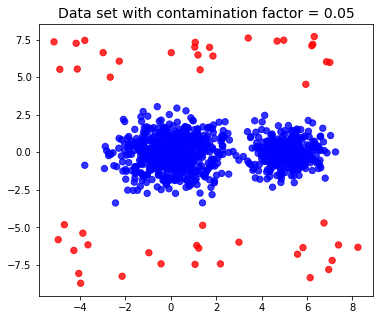

In [2]:
np.random.seed(331)
n = 1000
class_prior = 0.95 #real class prior
contamination = 1-class_prior

#Training set
a1_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a2_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a3_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a4_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a5_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
a6_ = np.random.randn(2, np.int(n*(1-class_prior)/6))#*0.6
num_anom = a1_.shape[1] + a2_.shape[1]+ a3_.shape[1] + a4_.shape[1] + a5_.shape[1]+ a6_.shape[1]

d1_ = np.random.randn(2, np.int(n*0.6))*1.1
n_ = n - d1_.shape[1] - num_anom
d2_ = np.random.randn(2, n_)*0.8

d2_[0, :] += 5

a1_[0, :] += 6.5
a1_[1, :] -= 6.5
a2_[0, :] -= 4.
a2_[1, :] -= 6.5
a3_[0, :] += 1.
a3_[1, :] -= 6.5
a4_[0, :] += 6.5
a4_[1, :] += 6.5
a5_[0, :] -= 4.
a5_[1, :] += 6.5
a6_[0, :] += 1.5
a6_[1, :] += 6.5


data_set = np.concatenate((a1_, a2_, a3_, a4_,a5_, a6_, d1_, d2_), axis=1)
X_train = data_set.T
y = np.zeros(n, dtype=np.int)
y[:num_anom] = +1

#Plot training and test sets
fig = plt.figure(figsize=(6, 5), facecolor='w', edgecolor='k')
colors = np.array(['b' if y[i] == 0 else 'r' for i in range(n)])# ['g', 'r'])
plt.scatter(X_train.T[0],X_train.T[1], 40, colors, alpha = 0.8)
plt.title("Data set with contamination factor = "+str(round(1-class_prior, 2)), fontsize=14)
plt.show()

# CAPe: Class prior estimation in Active Pu lEarning

In [3]:
#Inizialize two lists for AL strategy:
query_list = []                        #List of queried examples
labeled_ex = np.zeros(n, dtype=np.int) #List of labeled examples

#Inizialize all the parameters of our model
case = 2                               #0 -> perfect oracle, 2 -> imperfect oracle
k = 10                                 #Number of labeled examples required at each step
prior = 0.9                            #First guess of the prior
real_anomalies = np.where(y == 1)[0]   #If case = 2, you can use real_anomalies = []

#Estimate the density of examples
ker = KernelDensity().fit(X_train)
dmu = [np.exp(ker.score(X_train[i:i+1])) for i in range(n)]
mean_prob_term = math.log(np.mean(dmu),10) #Take the log density

In [ ]:
X_train.shape

### How to run CAPe with a single iteration

In [4]:
prior, labeled_ex, query_list = CAPe(X_train, labeled_ex, query_list, k, real_anomalies,\
                                       1-prior, mean_prob_term, case)
print("Estimated prior with k =", k, "labels:", prior)

(1000, 2)
(1000, 2)
Estimated prior with k = 10 labels: 0.8463472723960876


### How to run CAPe in a for loop querying labels

In [ ]:
prior = 0.9
ntimes = 20 #number of total iterations
k = 10

prior_list = np.zeros(ntimes, dtype= np.float)

for t in range(ntimes):
    prior, labeled_ex, query_list = CAPe(X_train, labeled_ex, query_list, k, real_anomalies,\
                                           1-prior, mean_prob_term, case)
    prior_list[t] = prior
    print("Iteration:",t,"prior:", prior)

### Final class prior results by using CAPe

In [ ]:
fig = plt.figure(figsize=(14, 6), facecolor='w', edgecolor='k')
real_prior = [class_prior for x in range(ntimes)]
plt.plot(np.arange(ntimes), prior_list, '--X', lw = 2, c = 'r', label = 'Estimated_prior')
plt.plot(np.arange(ntimes), real_prior, '--X', lw = 1, c = 'black', label = 'Real_prior')
plt.legend(fontsize = 14)
plt.xticks(np.arange(ntimes), np.arange(1,ntimes+1)*k)
plt.xlabel('Labeled examples', fontsize = 15)
plt.ylabel('Priors', fontsize = 15)
plt.title('Class Prior Estimation with Active Labels in PU data (CAPe)', fontsize = 18)
plt.show()